<a href="https://colab.research.google.com/github/miroorc/Capstone-Project/blob/main/BART_with__sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **This file uses summarized dataset to test model BART**

In [ ]:
pip install --upgrade datasets

In [ ]:
pip install transformers[torch]

In [ ]:
pip install transformers

In [ ]:
from datasets import load_dataset
ecthra = load_dataset("lex_glue", "ecthr_a")

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#Merge all the data together
from datasets import load_from_disk
sum_val = load_from_disk("/content/drive/MyDrive/sum_val")

In [ ]:
sum_train1 = load_from_disk("/content/drive/MyDrive/sum_train1")
sum_train2 = load_from_disk("/content/drive/MyDrive/sum_train2")
sum_train3 = load_from_disk("/content/drive/MyDrive/sum_train3")

In [ ]:
from datasets import concatenate_datasets

In [ ]:
sum_train=concatenate_datasets([sum_train1, sum_train2,sum_train3])

In [ ]:
ecthra['validation']=sum_val

In [ ]:
ecthra['train']=sum_train

In [ ]:
test=ecthra['test']

#convert label to one-hot form
import numpy as np
num_classes = 10

def one_hot_encode_multi(labels, num_classes):
    encoded_labels = np.zeros((len(labels),num_classes))
    for i, sublist in enumerate(labels):
        encoded_labels[i, sublist] = 1
    return encoded_labels

test_one_hot=one_hot_encode_multi(test['labels'],10)
test_one_hot = test_one_hot.tolist()
test=test.add_column(name="labels_one_hot", column=test_one_hot)

#clean the dataset to remove meaningless characters
import re
def format_text(text):
    text_format = []
    text=[[re.sub(r"^\d+\.\s*","",s) for s in sublst] for sublst in text]
    for each in text:
        text_format.append(''.join(each))
    return text_format

test_text_format=format_text(test['text'])
test=test.remove_columns('text')
test=test.add_column(name="text", column=test_text_format)
ecthra['test']=test






In [ ]:
ecthra['test']=ecthra['test'].remove_columns('labels')
ecthra['test']=ecthra['test'].rename_column('labels_one_hot', 'labels')


In [ ]:
from transformers import AutoTokenizer, BartForSequenceClassification

In [ ]:
model_ckpt = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")

In [ ]:
def tokenize_and_encode(examples):
  return tokenizer(examples["text"], truncation=True)

In [ ]:
cols = ecthra["train"].column_names
cols.remove("labels")
ds_enc = ecthra.map(tokenize_and_encode, batched=True, remove_columns=cols)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
ds_enc.set_format("torch")

In [ ]:
num_labels=10
model = BartForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, problem_type="multi_label_classification")

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

In [ ]:
model.to('cuda')

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps

In [ ]:
# define the arguments
batch_size = 10
metric_name = "f1"

In [ ]:
args = TrainingArguments(
    f"/content/drive/MyDrive/bart1",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [ ]:
# reference: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score,recall_score
from transformers import EvalPrediction
import sklearn.metrics as skm
import torch
import json


def multi_label_metrics(predictions, labels, threshold=0.6):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    recall=recall_score(y_true, y_pred, average='macro')
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    #matrixes = skm.confusion_matrix(y_true, y_pred)
    cm = skm.multilabel_confusion_matrix(y_true, y_pred).tolist()
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall':recall,
               'matrixes':cm

               }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
#define trainer
trainer = Trainer(
    model=model, args=args,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.evaluate()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Trainer is attempting to log a value of "[[[942, 1], [57, 0]], [[779, 28], [180, 13]], [[663, 150], [154, 33]], [[699, 1], [299, 1]], [[913, 0], [87, 0]], [[975, 21], [4, 0]], [[798, 160], [34, 8]], [[967, 0], [33, 0]], [[981, 1], [18, 0]], [[311, 550], [45, 94]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7164657115936279,
 'eval_f1': 0.1404997642621405,
 'eval_roc_auc': 0.5192763074585286,
 'eval_accuracy': 0.088,
 'eval_recall': 0.11138966178039414,
 'eval_matrixes': [[[942, 1], [57, 0]],
  [[779, 28], [180, 13]],
  [[663, 150], [154, 33]],
  [[699, 1], [299, 1]],
  [[913, 0], [87, 0]],
  [[975, 21], [4, 0]],
  [[798, 160], [34, 8]],
  [[967, 0], [33, 0]],
  [[981, 1], [18, 0]],
  [[311, 550], [45, 94]]],
 'eval_runtime': 23.4674,
 'eval_samples_per_second': 42.612,
 'eval_steps_per_second': 4.261}

In [ ]:
import torch
torch.cuda.empty_cache()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Recall,Matrixes
1,0.363300,0.351038,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
2,0.340400,0.342763,0.291262,0.602360,0.184000,0.100000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[0, 700], [0, 300]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
3,0.328500,0.343441,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
4,0.324200,0.340525,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
5,0.313600,0.349572,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
6,0.308100,0.356007,0.291262,0.602360,0.184000,0.100000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[0, 700], [0, 300]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
7,0.303400,0.340297,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
8,0.294300,0.324791,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
9,0.288200,0.301868,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"
10,0.279800,0.307534,0.000000,0.500000,0.175000,0.000000,"[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]"


Trainer is attempting to log a value of "[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[0, 700], [0, 300]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[700, 0], [300, 0]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958,

TrainOutput(global_step=9000, training_loss=0.3147357669406467, metrics={'train_runtime': 5200.7088, 'train_samples_per_second': 17.305, 'train_steps_per_second': 1.731, 'total_flos': 4.493740520680404e+16, 'train_loss': 0.3147357669406467, 'epoch': 10.0})

In [ ]:
x=trainer.evaluate()

Trainer is attempting to log a value of "[[[943, 0], [57, 0]], [[807, 0], [193, 0]], [[813, 0], [187, 0]], [[0, 700], [0, 300]], [[913, 0], [87, 0]], [[996, 0], [4, 0]], [[958, 0], [42, 0]], [[967, 0], [33, 0]], [[982, 0], [18, 0]], [[861, 0], [139, 0]]]" of type <class 'list'> for key "eval/matrixes" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


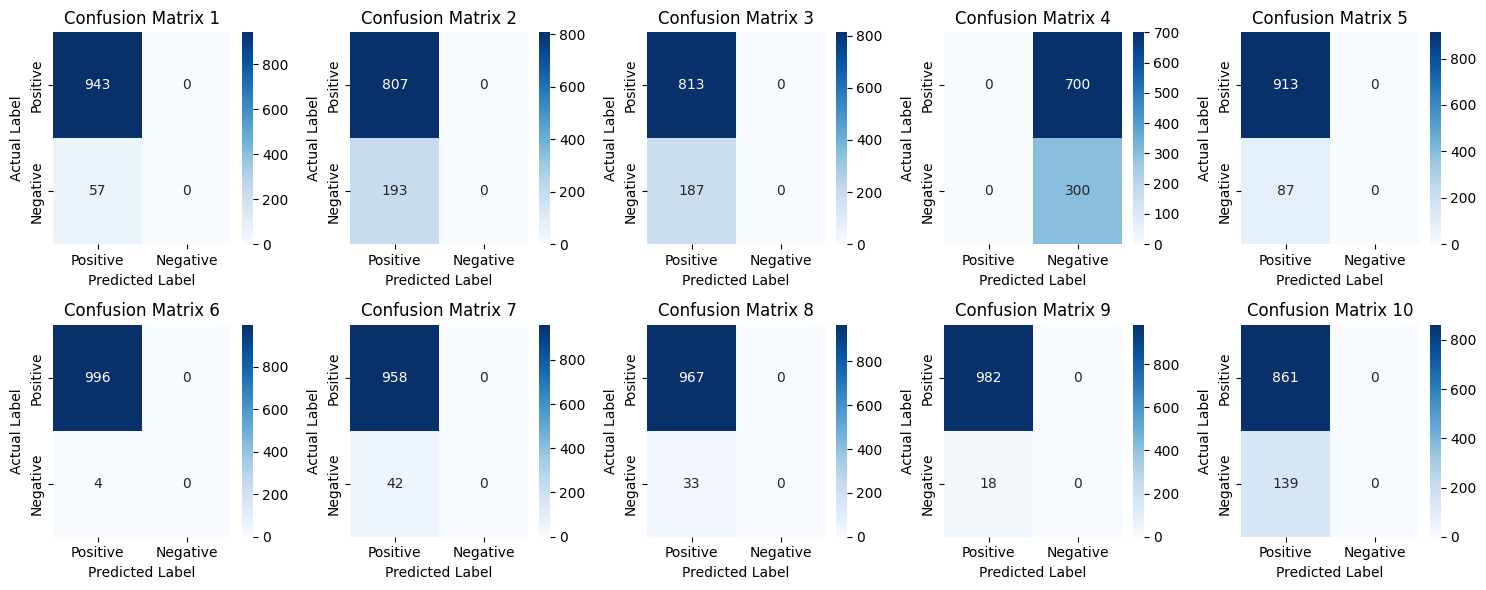

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrices = x['eval_matrixes']

# make picture of confusion matrix
labels = ['Positive', 'Negative']


fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Confusion Matrix {i+1}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')


plt.tight_layout()

plt.show()
